<h1><center> Basics of working with ERA5 Data <centre></h1>
This code shows the basics of downloading ERA5 data, exploring the variables, creating rasters using the data, clipping the rasters to shapefiles, and finding the average temperature of a region. 

<h3> <center> API request for ERA5 Data <center></h3>
    
For requesting ERA5 Data you need an account with the climate data store (CDS). You must follow the instructions [here](https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5) before running the API request. Specify the variables, times periods, area, and grid cell size you want (for ERA5 the maximum resolution is 0.28125 degrees). Note: If you are downloading large areas of data or hourly datasets only send a request for 1 or 2 years at a time for faster downloads. The code below is currenlty set to run for hourly data but can be changed for monthly averages as well. 

In [ ]:
import cdsapi

c = cdsapi.Client()
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type':'reanalysis',
        'variable':[
            'total_precipitation'
        ],
        'year':[1989
        ],
        'month':[
            '01','02','03',
            '04','05','06',
            '07','08','09',
            '10','11','12'
        ],
        'day':[
            '01','02','03',
            '04','05','06',
            '07','08','09',
            '10','11','12',
            '13','14','15',
            '16','17','18',
            '19','20','21',
            '22','23','24',
            '25','26','27',
            '28','29','30',
            '31'
        ],
        'time':[
            '00:00','01:00','02:00',
            '03:00','04:00','05:00',
            '06:00','07:00','08:00',
            '09:00','10:00','11:00',
            '12:00','13:00','14:00',
            '15:00','16:00','17:00',
            '18:00','19:00','20:00',
            '21:00','22:00','23:00'
        ],

        'grid': "0.28125 /0.28125 ",
        'area':"57/-128/49/-120",
        'format':'netcdf'
    },
    'download.nc')   

    

2019-08-16 09:41:59,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2019-08-16 09:42:00,686 INFO Request is queued
2019-08-16 09:42:01,817 INFO Request is running


<h3><center> Packages needed for data manipulation <center></h3>

In [1]:
from netCDF4 import Dataset,num2date
from datetime import date,datetime
import shapefile
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr,ogr

<h3><center> downloading.nc data <center></h3>
This data is monthly temperature and precipitation data that was downloaded from ERA5 (no the same data as is in the example API request). This code looks up the variables in the .nc file and extracts them. 

In [3]:
nc_file=Dataset('C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/RAW/ERA5_ma_PT_0.28res.nc')
nc_file.variables
temp=nc_file.variables['t2m'][:,:,:]
precip=nc_file.variables['tp'][:,:,:]
t=nc_file.variables['time'][:]
lat=nc_file.variables['latitude'][:]
long=nc_file.variables['longitude'][:]

<h3><center> Change time to datetime format <center></h3>
This section of code changes the orginal time format from the .nc to datetime format which is easier to work with

In [4]:
t_cal=nc_file.variables['time'].calendar
t_unit=nc_file.variables['time'].units
t_datetime=[]
t_datetime.append(num2date(t,units=t_unit,calendar=t_cal))
t_datetime=t_datetime[0]



<h3><center> Change temp from K to degree C <center></h3>
Change temperature from kelvin to degree C and create an array that matches the temperature estimation with its corresponding location
   

In [5]:
Z=[]
for i in np.arange(0,len(lat)):
    for j in np.arange(0,len(long)):
        Z.append([temp[0,i,j]-273.15,lat[i],long[j]])
Z=np.array(Z)

<h3> <center> Creating Temp Raster <center></h3>
Create a raster that contains one month of the temperature data. Note: Make sure to delete this raster before trying to make a new one with the same name!


In [6]:
temp_array=np.reshape(Z[:,0],(-1,len(lat)))
lat_array=np.reshape(Z[:,1], (-1,len(lat)))
lon_array=(Z[:,2],(-1,len(lat)))[0]


xmin,ymin,xmax,ymax = [lon_array.min(),lat_array.min(),lon_array.max(),lat_array.max()]
nrows,ncols = np.shape(temp_array)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0, -yres)  

output_raster = gdal.GetDriverByName('GTiff').Create('C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/Rasters/Temp_Jan1979_03res.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file

output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(3005)                     # This one specifies WGS84 lat long.
                                             # Anyone know how to specify the 
                                             # IAU2000:49900 Mars encoding?
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system                                                # to the file
output_raster.GetRasterBand(1).WriteArray(temp_array)   # Writes my array to the raster
output_raster.FlushCache()



<h2><center> Plotting Raster and Watersheds <center></h2>

In [9]:
import rasterio
import fiona
from descartes import PolygonPatch
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rasterio.mask


<h4>Raster Display</h4>

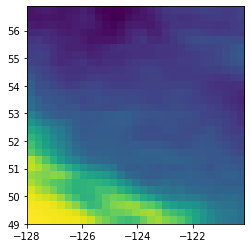

In [11]:
Temp_raster=rasterio.open('C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/Rasters/Temp_Jan1979_03res.tif')
with fiona.open("C:/Users/vore/Desktop/HydroMet_Project/Data/Shapefiles/ws_reprojected/watersheds.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]


rasterio.plot.show(Temp_raster,1)


<h4> Shapefile Display </h4>

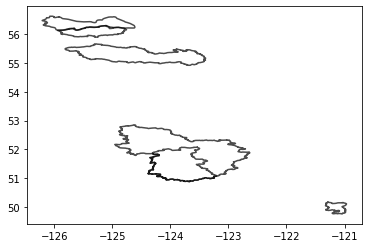

In [12]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
ws=gpd.read_file("C:/Users/vore/Desktop/HydroMet_Project/Data/Shapefiles/ws_reprojected/watersheds.shp")

for i in np.arange(0,6,1):
    x,y=ws['geometry'][i].exterior.xy
    plt.plot(x,y,color='k',alpha=0.7)
plt.show()

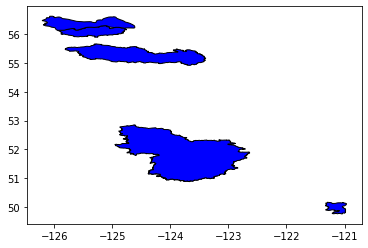

In [11]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

fig=plt.figure()
ax=fig.add_subplot(111)

for i in np.arange(0,6,1):
    ax.add_patch(PolygonPatch(ws['geometry'][i],fc='blue'))
ax.autoscale_view()

<h3><center> Masking Raster to Shapefiles<center></h3.


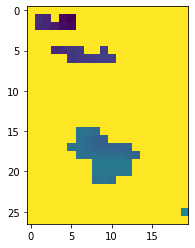

In [9]:

with fiona.open("C:/Users/vore/Desktop/HydroMet_Project/Data/Shapefiles/ws_reprojected/watersheds.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open("C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/Rasters/Temp_Jan1979_03res.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features,crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
show(out_image)

<h3><center> Average temperatures of watershed <center></h3>


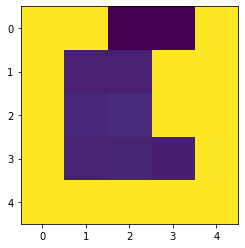

In [36]:

shapefile= fiona.open("C:/Users/vore/Desktop/HydroMet_Project/Data/Shapefiles/Individual_ws/Chilko/Chilko_WS.shp", "r") 
features=[]
for feature in shapefile:
    features.append(feature["geometry"])

with rasterio.open("C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/Rasters/Temp_Jan1979_03res.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features,crop=True)
    out_meta = src.meta.copy()
show(out_image)
out_image=out_image[0]

In [37]:
xrow, xcol=np.shape(out_image)
ws_temp=[]

for i in np.arange(0, xrow):
    for j in np.arange (0,xcol):
        if out_image[i,j] != 0:
            ws_temp.append(out_image[i,j])

np.mean(ws_temp)

-14.799602